In [728]:
import pandas as pd
import geopandas as gpd
from sklearn.metrics import precision_score, recall_score,mean_squared_error,r2_score,confusion_matrix
from scipy import stats
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [752]:
run = 6
description = "test - no segments"
agg = "segments"

In [753]:
#pred = pd.read_csv(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/classification_results.csv")

In [754]:
#pred.groupby('type_pred').size()

In [755]:
gt = gpd.read_file("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/Berlin/Radverkehr_priorisierungskonzept/priorisierungskonzept_validation.gpkg", 
                   dtype={"id": int})
gt = gt[["id", "gid", "ELEM_NR", "checked", "type_ground_truth", "quality_ground_truth"]]

In [756]:
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred_cycleways.shp")
columns = ["ID", "TYPE_PRED", "AVG_CLASS_", "WAY_LENGTH",  "AVG_QUALIT"]
if agg == "segments":
    columns += ["GROUP_NUM"]
pred = pred[columns]
pred.rename(columns={"ID":"id", "TYPE_PRED": "type_pred", "AVG_CLASS_": "avg_class_prob", "AVG_QUALIT": "avg_quality_pred"}, inplace=True)

In [734]:
df = gt.set_index("id").join(pred.set_index("id"))
df = df[df.type_pred.notna()]
df = df[df.type_ground_truth.notna()]
acc_type = (df.type_pred == df.type_ground_truth).sum() / len(df)
acc_type

0.900990099009901

In [735]:
df[df.type_pred == df.type_ground_truth].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

0.9146254514753059

In [736]:
# all asphalt benchmark
(df.type_ground_truth == "asphalt").sum() / len(df)

0.7504950495049505

In [737]:
# all asphalt benchmark
df[df.type_ground_truth == "asphalt"].WAY_LENGTH.sum() / df.WAY_LENGTH.sum()

0.7660905108976233

#### Confusion matrix surface types

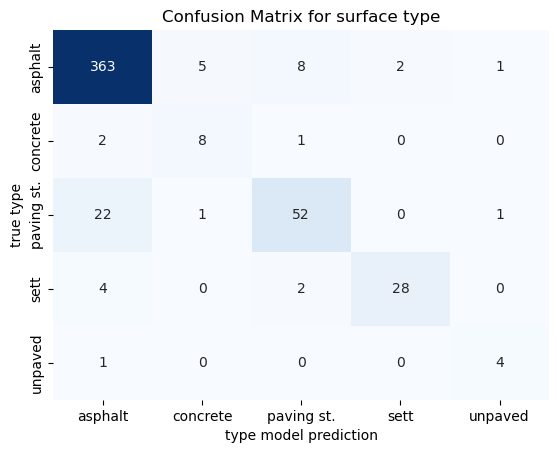

In [738]:
cm = confusion_matrix(df.type_ground_truth, df.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st.", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_run10.png", transparent=True, bbox_inches='tight')
plt.show()

In [739]:
# mismatched streets
m = df[df.type_pred != df.type_ground_truth]
m.reset_index(inplace=True)
pred = gpd.read_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/berlin_{agg}_pred_cycleways.shp")
misclassified = pred[pred.ID.isin(m.id)]

In [740]:
misclassified.to_file(f"/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/run{run}/misclassified_{agg}.gpkg", driver="GPKG")

### Quality

In [741]:
df["quality_ground_truth_float"] = df.quality_ground_truth.map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})

In [742]:
def quality_to_class(quality_float):
    if quality_float < 1.5:
        return "excellent"
    elif quality_float < 2.5:
        return "good"
    elif quality_float < 3.5:
        return "intermediate"
    elif quality_float < 4.5:
        return "bad"
    elif quality_float < 5.5:
        return "very_bad"
    else:
        return None
    
df["quality_pred"] = df.avg_quality_pred.apply(quality_to_class)

In [743]:
df.loc[df.avg_quality_pred > 6, "avg_quality_pred"] = None

In [744]:
df["deviation"] = df.quality_ground_truth_float - df.avg_quality_pred
df.deviation.describe()

count    502.000000
mean       0.005822
std        0.604712
min       -1.669580
25%       -0.433922
50%        0.060343
75%        0.333598
max        1.853381
Name: deviation, dtype: float64

In [745]:
df_quality = df[df.quality_ground_truth_float.notna() & df.avg_quality_pred.notna()] 
mse = mean_squared_error(df_quality.quality_ground_truth_float, df_quality.avg_quality_pred)
mse

0.36498150215216973

In [746]:
df.deviation.describe()

count    502.000000
mean       0.005822
std        0.604712
min       -1.669580
25%       -0.433922
50%        0.060343
75%        0.333598
max        1.853381
Name: deviation, dtype: float64

<Axes: >

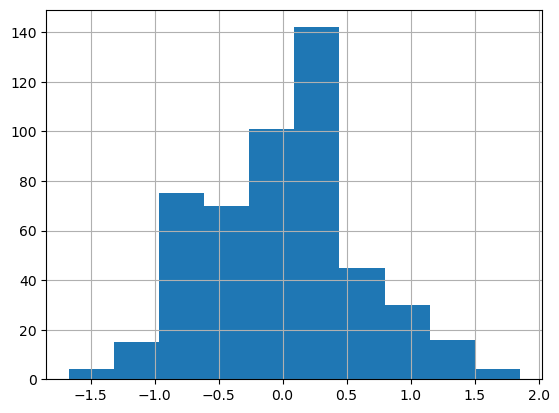

In [747]:
df.deviation.hist()

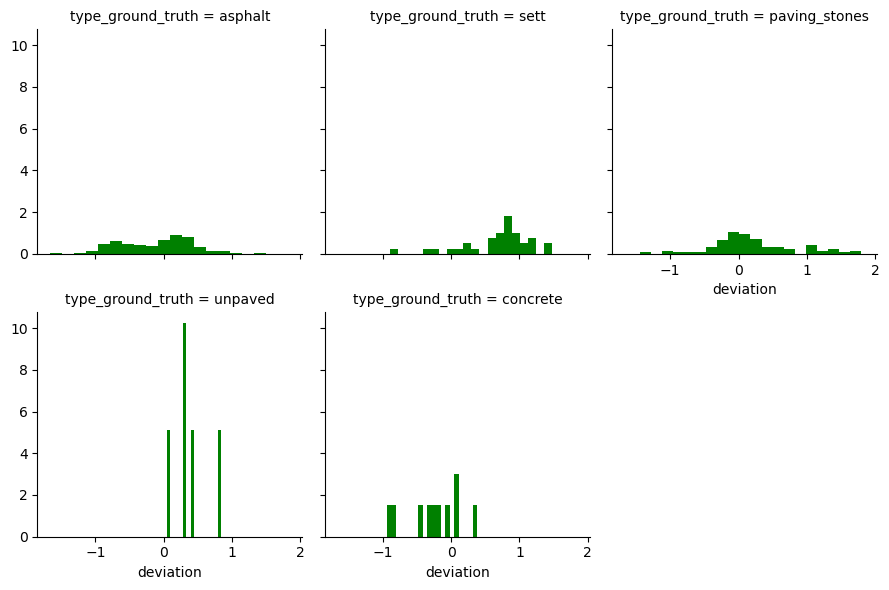

In [748]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df, col="type_ground_truth", col_wrap=3)

# Map histogram for a deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

# positive deviation means that the quality is overestimated

In [749]:
results_df = pd.DataFrame({
    'run':run,
    'description': description,
    'type_accuracy': [round(acc_type, 3)],
    'quality_mean_squared_error': [round(mse, 3)]
})

# Append results to CSV
csv_file_path = '/Users/alexandra/Documents/GitHub/road_network_classification/data/berlin_prio_vset/aggregation_alg_results.csv'
results_df.to_csv(csv_file_path, mode='a', header=not pd.io.common.file_exists(csv_file_path), index=False)
